This notebook contains an implementation of the [SimVP](https://arxiv.org/abs/2211.12509) architecture. The attention-based model SimVPv2 is compared with 2 baselines, namely PoolFormer and Inception Unet, considering the spatiotemporal predictive task on the Moving MNIST dataset. Both the input sequence and the future sequence to predict are made of 10 frames each.

#Preparation

##Install packages

*   `kornia` is a differentiable library used to perform filtering operation on images (compute gradients)
*   `pytorch_lightning` to use the lightning framework
*   `timm` library is used for weight initialization and Drop Path technique


In [ ]:
!pip install kornia
!pip install pytorch_lightning
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.9 MB/s eta 0:00:00


##Various imports and drive mounting

In [ ]:
import cv2
import imageio.v2 as imageio
import math
import random
import os
import os.path as osp
import gzip
import urllib.request

import numpy as np
from skimage.metrics import structural_similarity as cal_ssim
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

import kornia

import matplotlib.pyplot as plt
from PIL import Image
from timm.models.layers import DropPath, trunc_normal_

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#General Settings


*   `use_starReLU`: if `True`, instead of the GELU activation function, `StarReLU`, introduced in [MetaFormer Baselines for Vision](https://arxiv.org/abs/2210.13452v2) , is used
*   `use_diff_dev`: if `True`, add in the loss function a Differential Divergence Regularization term, proposed in [Temporal Attention Unit: Towards Efficient Spatiotemporal Predictive Learning](https://arxiv.org/abs/2206.12126). This helps the model learn the differences between consecutive predicted frames, hence can be used only when predicting more than one future frame
*   `use_gdl`: if `True` add in the loss function a Gradient Difference Loss, proposed in [Deep multi-scale video prediction beyond mean square error](https://arxiv.org/abs/1511.05440)
*   `log_step`: the number of epochs between each validation during training
*   `n_frames_input, n_frames_output`: the number of frames in input and the number of future frames to predict, respectively
*   `model_type`: the type of model used. It can be one of the following:
`incepu` or `metaformer`
*   `token_mixer`: the token mixer used in the MetaFormer architecture. It can be one of the following: `gsta` or `poolformer`. It is needed only when `model_type` is `metaformer`.


**With the current settings, the training session will take a full (free) Colab session of about 4h30min obtaining a test MSE of 40.0263** .

In [ ]:
use_starReLU = True
use_diff_dev = False
use_gdl = True
data_root = 'data/'

# training parameters
resume_training = False
eval_only = False
lr = 1e-3
batch_size = 16
drop_path = 0.0
num_epochs = 100
log_step = 5
use_augment = False
n_frames_input = 10
n_frames_output = 10

#model parameters
model_type = 'metaformer'  # ['incepu', 'metaformer']
if model_type == 'incepu':
    token_mixer = None
else:
    token_mixer = 'gsta'  # ['poolformer', 'gsta']

in_shape = [n_frames_input,1,64,64]
spatio_kernel_enc = 3
spatio_kernel_dec = 3
hid_S = 32
hid_T = 256
N_T = 4
N_S = 4

path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/MMNIST/Saving_dir/'
run_id = 'example/'
save_dir = path + run_id
log_dir = path + 'lightning_logs/'

os.makedirs(save_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

#StarReLU definition

In [ ]:
class StarReLU(nn.Module):
    """Implement StarReLU: s * relu(x) ** 2 + b
    s, b are either learnable or fixed.
    Code taken from the MetaFormer repository
    https://github.com/sail-sg/metaformer
    """

    def __init__(self, scale_value=1.0, bias_value=0.0,
                 scale_learnable=True, bias_learnable=True,
                 mode=None, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.relu = nn.ReLU(inplace=inplace)
        self.scale = nn.Parameter(scale_value * torch.ones(1),
                                  requires_grad=scale_learnable)
        self.bias = nn.Parameter(bias_value * torch.ones(1),
                                 requires_grad=bias_learnable)

    def forward(self, x):
        return self.scale * self.relu(x) ** 2 + self.bias

#Dataloaders

##MovingMNIST dataset handling

*   Training set of $\small 10000$ sequences generated on the fly from the static digits
*   Test set of $\small 10000$ sequences

In [ ]:
def load_mnist(root):
    """Load MNIST dataset for generating training data."""

    path = os.path.join(root, 'moving_mnist/train-images-idx3-ubyte.gz')
    with gzip.open(path, 'rb') as f:
        mnist = np.frombuffer(f.read(), np.uint8, offset=16)
        mnist = mnist.reshape(-1, 28, 28)
    return mnist


def load_fixed_set(root):
    """Load the fixed dataset"""

    path = os.path.join(root, 'moving_mnist/mnist_test_seq.npy')
    dataset = np.load(path)
    dataset = dataset[..., np.newaxis]
    return dataset


class MovingMNIST(Dataset):
    """Moving MNIST Dataset class.

    Args:
        root (str): Path to the dataset
        is_train (bool): Whether to use the train or test set
        n_frames_input, n_frames_output (int): The number of input and
                                               prediction video frames
        image_size (int): Input resolution of the data
        use_augment (bool): Whether to use augmentations
                            (default to False).
    """

    def __init__(self, root, is_train=True,
                 n_frames_input=10, n_frames_output=10,
                 image_size=64, use_augment=False):
        super().__init__()

        self.dataset = None
        self.is_train = is_train
        if self.is_train:
            self.mnist = load_mnist(root)
        else:
            self.dataset = load_fixed_set(root)

        self.length = int(1e4) if self.dataset is None \
                                else self.dataset.shape[1]

        self.n_frames_input = n_frames_input
        self.n_frames_output = n_frames_output
        self.n_frames_total = self.n_frames_input + self.n_frames_output
        self.use_augment = use_augment

        # Parameters to generate training data
        self._image_size = image_size
        self._digit_size = 28
        self._step_length = 0.1
        self.root = root

        self.mean = 0
        self.std = 1

    def get_random_trajectory(self, seq_length):
        """Generate a random sequence of a MNIST digit"""

        canvas_size = self._image_size - self._digit_size
        x = random.random()
        y = random.random()
        theta = random.random() * 2 * np.pi

        v_ys = [np.sin(theta)] * seq_length
        v_xs = [np.cos(theta)] * seq_length

        start_y = np.zeros(seq_length)
        start_x = np.zeros(seq_length)
        bounce_x = 1
        bounce_y = 1

        for i, v_x, v_y in zip(range(seq_length), v_xs, v_ys):
            # Take a step along velocity.
            y += bounce_y * v_y * self._step_length
            x += bounce_x * v_x * self._step_length

            # Bounce off edges.
            if x <= 0:
                x = 0
                bounce_x = -bounce_x
            if x >= 1.0:
                x = 1.0
                bounce_x = -bounce_x
            if y <= 0:
                y = 0
                bounce_y = -bounce_y
            if y >= 1.0:
                y = 1.0
                bounce_y = -bounce_y
            start_y[i] = y
            start_x[i] = x

        # Scale to the size of the canvas.
        start_y = (canvas_size * start_y).astype(np.int32)
        start_x = (canvas_size * start_x).astype(np.int32)
        return start_y, start_x

    def generate_moving_mnist(self, num_digits=2):
        """Get random trajectories for the digits
        and generate a video.
        """

        data = np.zeros((self.n_frames_total, self._image_size,
                         self._image_size), dtype=np.float32)
        for n in range(num_digits):
            # Generate trajectory
            start_y, start_x = self.get_random_trajectory(self.n_frames_total)
            ind = random.randint(0, self.mnist.shape[0] - 1)
            digit_image = self.mnist[ind]

            for i in range(self.n_frames_total):
                top = start_y[i]
                left = start_x[i]
                bottom = top + self._digit_size
                right = left + self._digit_size
                # Draw the digit
                data[i, top:bottom, left:right] = np.maximum(
                    data[i, top:bottom, left:right], digit_image)

        data = data[..., np.newaxis]
        return data

    def _augment_seq(self, imgs, crop_scale=0.94):
        """Augmentations for video"""

        _, _, h, w = imgs.shape  # original shape, e.g., [10, 1, 64, 64]
        imgs = F.interpolate(imgs, scale_factor=1 / crop_scale,
                             mode='bilinear')
        _, _, ih, iw = imgs.shape
        # Random Crop
        x = np.random.randint(0, ih - h + 1)
        y = np.random.randint(0, iw - w + 1)
        imgs = imgs[:, :, x:x+h, y:y+w]

        # Random Flip
        if random.randint(-2, 1):
            imgs = torch.flip(imgs, dims=(2,3))  # rotation 180
        elif random.randint(-2, 1):
            imgs = torch.flip(imgs, dims=(2, ))  # vertical flip
        elif random.randint(-2, 1):
            imgs = torch.flip(imgs, dims=(3, ))  # horizontal flip
        return imgs

    def __getitem__(self, idx):
        length = self.n_frames_input + self.n_frames_output
        if self.is_train:
            num_digits = 2
            # Generate data on the fly
            images = self.generate_moving_mnist(num_digits)
        else:
            images = self.dataset[:, idx, ...]

        # from [20, 64, 64, 1] to [20, 1, 64, 64]
        images = images.transpose(0,3,1,2)

        input = images[:self.n_frames_input]
        if self.n_frames_output > 0:
            output = images[self.n_frames_input:length]
        else:
            output = []

        output = torch.from_numpy(output / 255.0).contiguous().float()
        input = torch.from_numpy(input / 255.0).contiguous().float()

        if self.use_augment:
            imgs = self._augment_seq(torch.cat([input, output], dim=0),
                                     crop_scale=0.94)
            input = imgs[:self.n_frames_input, ...]
            output = imgs[self.n_frames_input:self.n_frames_input \
                                                +self.n_frames_output, ...]

        return input, output

    def __len__(self):
        return self.length

##Lightning Data Module

In [ ]:
class MMNISTDataModule(pl.LightningDataModule):
    """LightningDataModule to handle the MMNIST dataset
    using the Dataset class MovingMNIST
    """

    def __init__(self, root, n_frames_input=10, n_frames_output=10,
                 image_size=64, use_augment=False, batch_size=16):
        super().__init__()
        self.root = root
        self.n_frames_input = n_frames_input
        self.n_frames_output = n_frames_output
        self.image_size = image_size
        self.use_augment = use_augment
        self.batch_size = batch_size
        self.directory = self.root + 'moving_mnist/'

    def prepare_data(self):
        """Download the data"""

        os.makedirs(self.directory, exist_ok=True)

        urllib.request.urlretrieve(
            ('http://www.cs.toronto.edu/~nitish/'
             'unsupervised_video/mnist_test_seq.npy'),
            os.path.join(self.directory, 'mnist_test_seq.npy'))

        urllib.request.urlretrieve(
            'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            os.path.join(self.directory, 'train-images-idx3-ubyte.gz'))

    def setup(self, stage):
        """"Assign train and test set."""

        self.train_set = MovingMNIST(root=self.root, is_train=True,
                                     n_frames_input=self.n_frames_input,
                                     n_frames_output=self.n_frames_output,
                                     image_size=self.image_size,
                                     use_augment=self.use_augment)

        self.test_set = MovingMNIST(root=self.root, is_train=False,
                                  n_frames_input=self.n_frames_input,
                                  n_frames_output=self.n_frames_output,
                                  image_size=self.image_size,
                                  use_augment=False)

    def train_dataloader(self):
        """Generate dataloader for training."""

        dataloader_train = torch.utils.data.DataLoader(
            self.train_set, batch_size=self.batch_size, shuffle=True,
            pin_memory=True, drop_last=True)
        return dataloader_train

    def test_dataloader(self):
        """Generate dataloader for testing."""

        dataloader_test = torch.utils.data.DataLoader(
            self.test_set, batch_size=self.batch_size, shuffle=False,
            pin_memory=True, drop_last=False)
        return dataloader_test

    def val_dataloader(self):
        """Generate dataloader for validation."""

        dataloader_vali = torch.utils.data.DataLoader(
            self.test_set, batch_size=self.batch_size, shuffle=False,
            pin_memory=True, drop_last=False)
        return dataloader_vali

    def predict_dataloader(self):
        """Generate dataloader for prediction."""

        dataloader_predict = torch.utils.data.DataLoader(
            self.test_set, batch_size=self.batch_size, shuffle=False,
            pin_memory=True, drop_last=False)
        return dataloader_predict

#Helper functions

*  *Mean Squared Error* (*MSE*): it evaluates the MSE between predicted and ground truth future frames
*   *Structural Similarity Index* (*SSIM*) : it evaluates not only pixel-wise differences but also structural information. It compares local patterns of pixel intensity, luminance, contrast and structure to determine similarity between images. It is a value in the interval $\small [0,1]$, where a value of $\small 1$ means the images are identical
*   *Gradient Difference Loss*: $\small GDL=\frac{1}{BTCHW}\sum(Y_x-\hat{Y}_x)^2+(Y_y-\hat{Y}_y)^2$ where $\small Y,\hat{Y}$ are the predicted and ground truth tensors, $\small I_x,I_y$ are the gradient along $\small x,y$ of the tensor $\small I$ and the summation is along all the $\small 5$ tensor dimensions
*   *Differential Divergence Regularization*: it is the Kullback-Leibler divegence between the probability distributions $\small \sigma(\Delta\hat{Y}), \sigma(\Delta Y)$ where $\small \sigma(\cdot)$ is the softmax and $\Delta\hat{Y}, \Delta Y$ are the forward differences of the predicted and ground truth frames
*   *show_video_gif_multiple*: generate a gif using the input, predicted and ground truth frames

In [ ]:
def MSE(pred, true):
    """Return the Mean Squared error between the input image sequences.

    It is normalized only on the batch and time axis,
    and it is used to evaluate the model at the end of training.
    """

    return torch.mean((pred-true)**2, dim=(0, 1)).sum()

def SSIM(pred, true):
    """Returns the Structural Similarity Index Measure
    between the input image sequences.
    """

    ssim = 0
    for b in range(pred.shape[0]):
        for f in range(pred.shape[1]):
            ssim += cal_ssim(pred[b, f].swapaxes(0, 2).cpu().numpy(),
                             true[b, f].swapaxes(0, 2).cpu().numpy(),
                             channel_axis=-1)
    return ssim / (pred.shape[0] * pred.shape[1])

def diff_div_reg(pred_y, batch_y, tau=0.1, eps=1e-12):
    """Differential Divergence Regularization term.

    Code taken from https://github.com/chengtan9907/OpenSTL
    """

    B, T, C = pred_y.shape[:3]
    gap_pred_y = (pred_y[:, 1:] - pred_y[:, :-1]).reshape(B, T-1, -1)
    gap_batch_y = (batch_y[:, 1:] - batch_y[:, :-1]).reshape(B, T-1, -1)
    softmax_gap_p = F.softmax(gap_pred_y / tau, -1)
    softmax_gap_b = F.softmax(gap_batch_y / tau, -1)
    loss_gap = softmax_gap_p * \
        torch.log(softmax_gap_p / (softmax_gap_b + eps) + eps)
    return loss_gap

def gdl_criterion(batch_pred, batch_true):
    """Gradient Difference Loss.

    Implemented using the differentiable library kornia.
    """

    B, T, C, H , W = batch_pred.shape
    batch_pred = batch_pred.view(B*T, C, H, W)

    batch_true = batch_true.view(B*T, C, H, W)

    pred_grads = kornia.filters.spatial_gradient(batch_pred)
    dx_pred = torch.abs(pred_grads[:,:,0,:,:])
    dy_pred = torch.abs(pred_grads[:,:,1,:,:])

    true_grads = kornia.filters.spatial_gradient(batch_true)
    dx_true = torch.abs(true_grads[:,:,0,:,:])
    dy_true = torch.abs(true_grads[:,:,1,:,:])

    diff_gradients = (dx_true - dx_pred)**2 + (dy_true - dy_pred)**2
    prediction_error = torch.mean(diff_gradients)
    return prediction_error

def show_video_gif_multiple(prev, true, pred, out_path=None, use_rgb=False):
    """Generate gif with a video sequence

    Code taken from https://github.com/chengtan9907/OpenSTL .
    """

    def swap_axes(x):
        if len(x.shape) > 3:
            return x.swapaxes(1,2).swapaxes(2,3)
        else: return x

    prev, true, pred = map(swap_axes, [prev, true, pred])
    prev_frames = prev.shape[0]
    frames = prev_frames + true.shape[0]
    images = []
    for i in range(frames):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
        for t, ax in enumerate(axes):
            if t == 0:
                plt.text(0.3, 1.05, 'ground truth', fontsize=15,
                         color='green', transform=ax.transAxes)
                if i < prev_frames:
                    if use_rgb:
                        ax.imshow(cv2.cvtColor(prev[i], cv2.COLOR_BGR2RGB))
                    else:
                        ax.imshow(prev[i], cmap='gray')
                else:
                    if use_rgb:
                        ax.imshow(cv2.cvtColor(true[i-frames],
                                               cv2.COLOR_BGR2RGB))
                    else:
                        ax.imshow(true[i-frames], cmap='gray')
            elif t == 1:
                if i < prev_frames:
                    plt.text(0.3, 1.05, 'input frames', fontsize=15,
                             color='red', transform=ax.transAxes)
                    if use_rgb:
                        ax.imshow(cv2.cvtColor(prev[i], cv2.COLOR_BGR2RGB))
                    else:
                        ax.imshow(prev[i], cmap='gray')
                else:
                    plt.text(0.2, 1.05, 'predicted frames', fontsize=15,
                             color='red', transform=ax.transAxes)
                    if use_rgb:
                        ax.imshow(cv2.cvtColor(pred[i-frames],
                                               cv2.COLOR_BGR2RGB))
                    else:
                        ax.imshow(pred[i-frames], cmap='gray')
            ax.axis('off')
        plt.savefig('./tmp.png', bbox_inches='tight', format='png')
        images.append(imageio.imread('./tmp.png'))
    plt.close()
    os.remove('./tmp.png')

    if out_path is not None:
        if not out_path.endswith('gif'):
            out_path = out_path + '.gif'
        imageio.mimsave(out_path, images)

#Model architecture
The non-Lightning code is an adaptation of some modules offered in the zoo of the repository [OpenSTL](https://github.com/chengtan9907/OpenSTL), that has been also further documented and adapted to follow the [PEP8](https://peps.python.org/pep-0008/) formatting rules

##Basic modules

In [ ]:
class BasicConv2d(nn.Module):
    """This class implements a 2D convolution.

    if act_norm=True it also performs group normalization
    and applies SiLU activation.

    if upsampling=True the input is upsampled 2x
    using the PixelShuffle method.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 upsampling=False,
                 act_norm=False):
        super().__init__()
        self.act_norm = act_norm
        if upsampling is True:
            self.conv = nn.Sequential(
                *[nn.Conv2d(in_channels, out_channels*4,
                            kernel_size=kernel_size,
                            stride=1, padding=padding,
                            dilation=dilation),
                # Height and width are doubled, number of channels is /4
                nn.PixelShuffle(2)
            ])
        else:
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation)

        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.SiLU(True)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Perform convolution and possibly
        activation + normalization.
        """

        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    """Performs 2D convolution and can perform downsampling
    setting the kernel stride to 2.
    """

    def __init__(self,
                 C_in,
                 C_out,
                 kernel_size=3,
                 downsampling=False,
                 upsampling=False,
                 act_norm=True):
        super().__init__()

        stride = 2 if downsampling is True else 1

        # This padding is so that the output dim is
        # (dim_in)/stride
        padding = (kernel_size - stride + 1) // 2

        self.conv = BasicConv2d(C_in, C_out, kernel_size=kernel_size,
                                stride=stride, upsampling=upsampling,
                                padding=padding, act_norm=act_norm)

    def forward(self, x):
        """Forward the model.

        It simply calls BasicConv2d but handles downsampling.
        """

        y = self.conv(x)
        return y

class GroupConv2d(nn.Module):
    """Performs 2D Convolution, group Normalization
    and activation using Leaky ReLU.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 groups=1,
                 act_norm=False,
                 act_inplace=True):
        super().__init__()
        self.act_norm=act_norm
        if in_channels % groups != 0:
            groups=1
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=act_inplace)

    def forward(self, x):
        """Forward the model."""

        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y

def sampling_generator(N, reverse=False):
    """Helper function to regulate the downsampling
    and upsampling in the encoder and decoder.
    """

    samplings = [False, True] * (N // 2)
    if reverse:
        return list(reversed(samplings[:N]))
    else:
        return samplings[:N]


class Encoder(nn.Module):
    """3D Encoder for SimVP."""

    def __init__(self, C_in, C_hid, N_S, spatio_kernel):
        samplings = sampling_generator(N_S)
        super().__init__()
        self.enc = nn.Sequential(
              ConvSC( C_in, C_hid, spatio_kernel, downsampling=samplings[0]),
              *[ConvSC(C_hid, C_hid, spatio_kernel, downsampling=s) for s \
                in samplings[1:]]
        )

    def forward(self, x):
        """The forward method returns both the output
        of the encoder and the output of the
        first encoder sub block, to be used in the decoder
        for the skip connection.
        """

        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1, len(self.enc)):
            latent = self.enc[i](latent)
        return latent, enc1


class Decoder(nn.Module):
    """3D Decoder for SimVP"""

    def __init__(self, C_hid, C_out, N_S, spatio_kernel):
        samplings = sampling_generator(N_S, reverse=True)
        super().__init__()
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, spatio_kernel, upsampling=s) for s \
              in samplings[:-1]],
            ConvSC(C_hid, C_hid, spatio_kernel, upsampling=samplings[-1])
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)

    def forward(self, hid, enc1=None):
        """It forward the data through the decoder sub blocks
        and uses the output of the first sub block of the encoder.
        """

        for i in range(0, len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](hid + enc1)
        Y = self.readout(Y)
        return Y

##Metaformer Modules
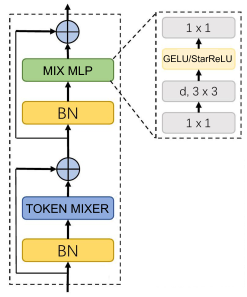

###Shared MetaFormer modules

In [ ]:
class MixMlp(nn.Module):
    """Mlp block for Metaformer"""

    def __init__(self,
                 in_features,
                 hidden_features=None, out_features=None,
                 act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)  # 1x1
        self.dwconv = nn.Conv2d(hidden_features, hidden_features, 3, 1, 1,
                                bias=True, groups=hidden_features)
        self.act = act_layer()  # GELU
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)  # 1x1
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        """MLP implementation."""

        x = self.fc1(x)
        x = self.dwconv(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class MetaFormer(nn.Module):
    """MetaFormer block.

    token_mixer specifies the token mixer to use.
    It can be either 'gsta' or 'poolformer'.
    """

    def __init__(self, dim, kernel_size=21, mlp_ratio=4., token_mixer='gsta',
                 drop=0., drop_path=0.1, init_value=1e-2, act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(dim)

        if token_mixer == 'gsta':
            self.token_mixer = SpatialAttention(dim, kernel_size)
        elif token_mixer == 'poolformer':
            self.token_mixer = Pooling(pool_size=3)
        else:
            raise Exception(f"Token mixer {token_mixer} not supported")

        if drop_path > 0.:
            self.drop_path = DropPath(drop_path)
        else:
            self.drop_path = nn.Identity()

        self.norm2 = nn.BatchNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MixMlp(in_features=dim, hidden_features=mlp_hidden_dim,
                          act_layer=act_layer, drop=drop)

        self.layer_scale_1 = nn.Parameter(init_value * torch.ones((dim)),
                                          requires_grad=True)
        self.layer_scale_2 = nn.Parameter(init_value * torch.ones((dim)),
                                          requires_grad=True)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = x \
            + self.drop_path(self.layer_scale_1.unsqueeze(-1).unsqueeze(-1)
                             * self.token_mixer(self.norm1(x)))
        x = x \
            + self.drop_path(self.layer_scale_2.unsqueeze(-1).unsqueeze(-1)
                             * self.mlp(self.norm2(x)))
        return x

class MidMetaNet(nn.Module):
    """The hidden Translator of MetaFormer for SimVP."""

    def __init__(self, channel_in, channel_hid, N2, token_mixer='gsta',
                 mlp_ratio=4., drop=0.0, drop_path=0.1):
        super().__init__()
        assert N2 >= 2 and mlp_ratio > 1
        self.N2 = N2
        dpr = [x.item() for x in torch.linspace(1e-2, drop_path, self.N2)]

        # expansion
        enc_layers = [
            MetaFormer(channel_in, kernel_size=21, mlp_ratio=mlp_ratio,
                       token_mixer=token_mixer, drop=drop, drop_path=dpr[0],
                       act_layer=StarReLU if use_starReLU else nn.GELU)
            ]
        if channel_in != channel_hid:
            enc_layers.append(nn.Conv2d(channel_in, channel_hid, kernel_size=1))

        # middle layers
        for i in range(1, N2-1):
            enc_layers.append(
                MetaFormer(channel_hid, kernel_size=21,
                           mlp_ratio=mlp_ratio, token_mixer=token_mixer,
                           drop=drop, drop_path=dpr[i],
                           act_layer=StarReLU if use_starReLU else nn.GELU)
                )
        # contraction
        enc_layers.append(
            MetaFormer(channel_hid, kernel_size=21, mlp_ratio=mlp_ratio,
                       token_mixer=token_mixer, drop=drop, drop_path=drop_path,
                       act_layer=StarReLU if use_starReLU else nn.GELU)
            )

        if channel_in != channel_hid:
            enc_layers.append(nn.Conv2d(channel_hid, channel_in, kernel_size=1))
        self.enc = nn.Sequential(*enc_layers)

    def forward(self, x):
        """Forward in the temporal translator architecture."""

        B, T, C, H, W = x.shape
        x = x.view(B, T*C, H, W)
        z = self.enc(x)
        y = z.view(B, T, C, H, W)
        return y

###SimVPv2 modules
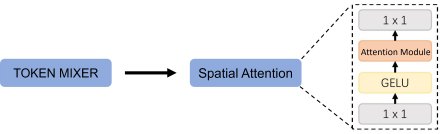

In [ ]:
class AttentionModule(nn.Module):
    """Large Kernel Attention.

    A KxK convolution is decomposed into:
        (2d - 1) x (2d - 1) depth-wise convolution
        K/d x K/d depth-wise dilation convolution with dilation d
        1 x 1 convolution

    Hereafter, K is the kernel_size passed to the constructor.
    """

    def __init__(self, num_channels, kernel_size, dilation=3):
        super().__init__()
        # Kernel size and padding for depth wise conv.
        # H,W of the input stay unchanged
        dw_k = 2 * dilation - 1
        dw_p = (dw_k - 1) // 2

        # Kernel size and padding for depth wise dilation conv.
        # The second term in dd_k keeps the size of the kernel odd
        # H,W of the input stay unchanged.
        dd_k = kernel_size // dilation + ((kernel_size // dilation) % 2 - 1)
        dd_p = (dilation * (dd_k - 1) // 2)

        self.depth_wise_conv = nn.Conv2d(num_channels, num_channels,
                                         kernel_size=dw_k, padding=dw_p,
                                         groups=num_channels)
        self.depth_wise_dil_conv = nn.Conv2d(num_channels, num_channels,
                                             kernel_size=dd_k, padding=dd_p,
                                             groups=num_channels,
                                             dilation=dilation)

        # Channelwise 1x1 convolution
        self.conv1 = nn.Conv2d(num_channels, 2*num_channels, 1)

    def forward(self, x):
        """Perform in sequence the 3 convolutions
        and then split along the channel dimension,
        gate with the sigmoid and perform element-wise multiplication.
        """

        x = self.depth_wise_conv(x)
        x = self.depth_wise_dil_conv(x)

        f_g = self.conv1(x)

        # Split along the channel dimension.
        split_dim = f_g.shape[1] // 2

        f_x, g_x = torch.split(f_g, split_dim, dim=1)
        return torch.sigmoid(g_x) * f_x

class SpatialAttention(nn.Module):
    """A Spatial Attention block for SimVP.

    It implements the SimVPv2 token mixer block.
    """

    def __init__(self, d_model, kernel_size=21, attn_shortcut=True):
        super().__init__()

        self.proj_1 = nn.Conv2d(d_model, d_model, 1)  # 1x1 conv
        self.activation = StarReLU() if use_starReLU else nn.GELU()
        self.spatial_gating_unit = AttentionModule(d_model, kernel_size)
        self.proj_2 = nn.Conv2d(d_model, d_model, 1)  # 1x1 conv
        self.attn_shortcut = attn_shortcut

    def forward(self, x):
        """Forward the token mixer."""

        if self.attn_shortcut:
            shortcut = x.clone()
        x = self.proj_1(x)
        x = self.activation(x)
        x = self.spatial_gating_unit(x)
        x = self.proj_2(x)
        if self.attn_shortcut:
            x = x + shortcut
        return x


###PoolFormer modules
poolformer_13.png

In [ ]:
class Pooling(nn.Module):
    """Implementation of PoolFormer token mixer."""

    def __init__(self, pool_size=3):
        super().__init__()
        self.pool = nn.AvgPool2d(
            pool_size, stride=1, padding=pool_size//2,
            count_include_pad=False)

    def forward(self, x):
        """Subtract the input after the avg since in the
        metaformer block you already have a residual connection.
        """

        return self.pool(x) - x

##Inception baseline modules
On the left the *Inception* block, on the right the *Inception Unet*
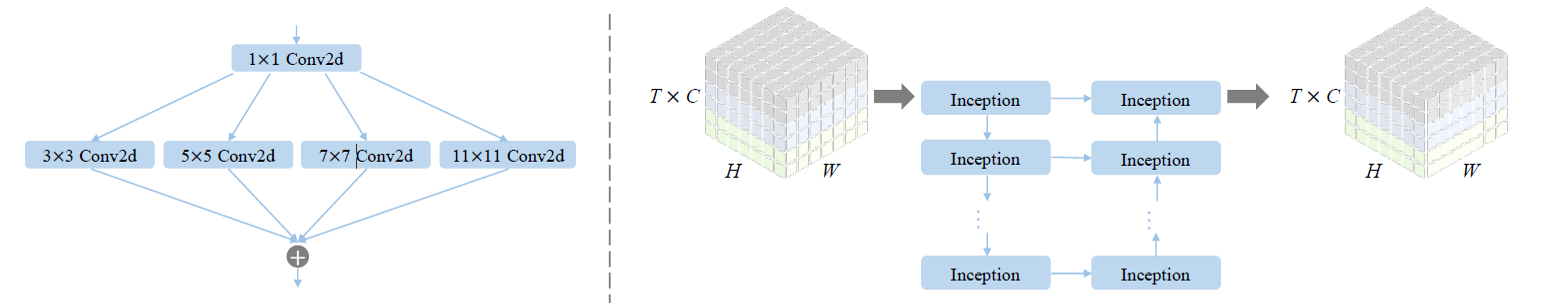



In [ ]:
class gInception_ST(nn.Module):
    """IncepU block for SimVP."""

    def __init__(self, C_in, C_hid, C_out,
                 incep_ker = [3,5,7,11], groups = 8):
        super().__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1,
                               stride=1, padding=0)

        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(
                C_hid, C_out, kernel_size=ker, stride=1,
                padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        """Forward in the inception block.

        Process x in parallel and add the results.
        """

        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y

class MidIncepNet(nn.Module):
    """The hidden Translator of IncepNet for Inception Unet"""

    def __init__(self, channel_in, channel_hid, N2,
                 incep_ker=[3,5,7,11], groups=8):
        super().__init__()
        assert N2 >= 2 and len(incep_ker) > 1
        self.N2 = N2
        enc_layers = [gInception_ST(channel_in, channel_hid//2,
                                    channel_hid, incep_ker=incep_ker,
                                    groups=groups)]

        for i in range(1,N2-1):
            enc_layers.append(gInception_ST(channel_hid, channel_hid//2,
                                            channel_hid, incep_ker=incep_ker,
                                            groups=groups))
        enc_layers.append(gInception_ST(channel_hid, channel_hid//2,
                                        channel_hid, incep_ker=incep_ker,
                                        groups=groups))
        dec_layers = [
                gInception_ST(channel_hid, channel_hid//2, channel_hid,
                              incep_ker=incep_ker, groups=groups)]
        for i in range(1,N2-1):
            dec_layers.append(
                gInception_ST(2*channel_hid, channel_hid//2, channel_hid,
                              incep_ker=incep_ker, groups=groups))
        dec_layers.append(
                gInception_ST(2*channel_hid, channel_hid//2, channel_in,
                              incep_ker=incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        """Forward in the incepU architecture."""

        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # Encoder
        skips = []
        z = x
        for i in range(self.N2):
            z = self.enc[i](z)
            if i < self.N2-1:
                skips.append(z)
        # Decoder: all block but the first take as input
        # the concatenation of the previous decoder block
        # and the respective encoder output
        z = self.dec[0](z)
        for i in range(1,self.N2):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y

##Lightning Model



In [ ]:
class LightningSimVPModel(pl.LightningModule):
    """SimVP Model implementation in Pytorch Lightning
    """

    def __init__(self, in_shape, hid_S=16, hid_T=256, N_S=4, N_T=4,
                 model_type='metaformer', token_mixer='gsta',
                 mlp_ratio=8., drop=0.0, drop_path=0.0,
                 spatio_kernel_enc=3, spatio_kernel_dec=3,
                 use_diff_dev=False, use_gdl=False,
                 lr=1e-3, num_epochs=100,
                 steps_per_epoch=1e4/16, n_frames_output=10):
        super().__init__()
        T, C, H, W = in_shape  # T is the number of input frames

        self.enc = Encoder(C, hid_S, N_S, spatio_kernel_enc)
        self.model_type = model_type
        if self.model_type == 'incepu':
            self.hid = MidIncepNet(T*hid_S, hid_T, N_T)
        else:
            self.token_mixer = token_mixer
            self.hid = MidMetaNet(T*hid_S, hid_T, N_T,
                                  token_mixer=self.token_mixer,
                                  mlp_ratio=mlp_ratio,
                                  drop=drop, drop_path=drop_path)

        self.dec = Decoder(hid_S, C, N_S, spatio_kernel_dec)

        self.use_gdl = use_gdl
        self.use_diff_dev = use_diff_dev
        self.lr = lr
        self.num_epochs = num_epochs
        self.steps_per_epoch = steps_per_epoch
        self.n_frames_output = n_frames_output
        self.save_hyperparameters()

    def forward(self, x_raw):
        """Forward in the SimVP model.

        The output shape is the same of the input,
        so BxTxCxHxW.
        """

        B, T, C, H, W = x_raw.shape
        x = x_raw.view(B*T, C, H, W)


        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)

        return Y

    def predict(self, batch_x):
        """ This function output the tensor with the desired
        number of output frames.

        Since the output of the forward method has the same shape
        as the input but the number of output frames to predict
        may be different from T, i.e., it may be different from the
        number of input frames, in this function the output is
        BxT'xCxHxW with T' the number of desired output frames.
        """

        n_frames_input = batch_x.shape[1]

        pred = self.forward(batch_x)

        # if T'<T discard the last T-T' frames
        if self.n_frames_output < n_frames_input:
            pred = pred[:, :self.n_frames_output]
        # if T'>T predict the extra T'-T frames autoregressively
        elif self.n_frames_output > n_frames_input:
            pred = []
            d = self.n_frames_output // n_frames_input
            m = self.n_frames_output % n_frames_input

            cur_seq = batch_x.clone()
            for _ in range(d):
                cur_seq = model(cur_seq)
                pred.append(cur_seq)

            if m != 0:
                cur_seq = model(cur_seq)
                pred.append(cur_seq[:, :m])

            pred = torch.cat(pred, dim=1)

        return pred

    def configure_optimizers(self):
      """Return the optimizer and the learning rate scheduler."""

      optimizer = optim.Adam(self.parameters(), lr=self.lr)

      total_steps = self.num_epochs * self.steps_per_epoch
      lr_scheduler = optim.lr_scheduler.OneCycleLR(
          optimizer,
          max_lr=self.lr,
          total_steps=total_steps,
          final_div_factor=1e4)

      lr_scheduler_config = {
          'scheduler': lr_scheduler,
          'interval': 'step',
          'frequency': 1
      }

      return {
          'optimizer': optimizer,
          'lr_scheduler': lr_scheduler_config
      }

    def loss_fn(self, pred, target):
        """Defines the loss function of the model.

        The loss is made of the MSE, and then two other terms
        are added with some weights if the respective flags are True.
        """

        gdl = gdl_criterion(pred, target) if self.use_gdl else 0
        diff_dev = diff_div_reg(pred, target).mean() if self.use_diff_dev else 0
        mse_fun = nn.MSELoss()
        mse = mse_fun(pred, target)

        return mse + 0.5*gdl + 0.1*diff_dev

    def training_step(self, train_batch, batch_idx):
        """Define a single training step.

        Note how the 'predict' function is used, rather than 'forward'.
        """

        x, y = train_batch
        pred = self.predict(x)
        loss = self.loss_fn(pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True,
                 prog_bar=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        """Define a single validation step.

        Note how the 'predict' function is used, rather than 'forward'.
        """

        x, y = val_batch
        pred = self.predict(x)
        loss = self.loss_fn(pred, y)
        mse = MSE(pred,y)
        self.log('val_loss', loss)
        self.log('val_mse',mse)
        return loss

    def test_step(self, val_batch, batch_idx):
        """Define a single test step.

        Note how the 'predict' function is used, rather than 'forward'.
        We log the test MSE and SSIM to then compare different models.
        """

        x, y = val_batch
        pred = self.predict(x)
        loss = self.loss_fn(pred, y)
        mse = MSE(pred,y)
        ssim = SSIM(pred,y)

        eval_res = {}
        eval_res['loss'] = loss
        eval_res['mse'] = mse
        eval_res['ssim'] = ssim
        self.log('test_loss', loss)
        self.log('test_mse',mse)
        self.log('test_ssim',ssim)
        return eval_res

    def predict_step(self, val_batch, batch_idx):
        """Define a single prediction step.

        Note how the 'predict' function is used, rather than 'forward'.
        We do not compute metrics but return a tuple of three tensors
        (input, prediction, ground_truth) and this is used
        to compare the images in the evaluation phase.
        """

        x, y = val_batch
        return (x, self.predict(x), y)

#Model instantiation

In [ ]:
pl.seed_everything(42, workers=True)  # for reproducibility

data_module = MMNISTDataModule(root=data_root, n_frames_input=n_frames_input,
                               n_frames_output=n_frames_output,
                               image_size=in_shape[-1], use_augment=use_augment,
                               batch_size=batch_size)

model = LightningSimVPModel(in_shape, hid_S, hid_T, N_S, N_T,
                            model_type=model_type, token_mixer=token_mixer,
                            drop_path=drop_path,
                            spatio_kernel_enc=spatio_kernel_enc,
                            spatio_kernel_dec=spatio_kernel_dec,
                            use_diff_dev=use_diff_dev, use_gdl=use_gdl, lr=lr,
                            num_epochs=num_epochs,
                            steps_per_epoch=int(1e4/batch_size),
                            n_frames_output=n_frames_output)

# Save best model based on validation loss
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor='val_loss',
                                      mode='min', dirpath=save_dir,
                                      filename='best_val_loss')
# Save most recent model
checkpoint_callback_last = ModelCheckpoint(save_on_train_epoch_end=True,
                                           filename='last',
                                           dirpath=save_dir)

logger = TensorBoardLogger(path, version=run_id)

trainer = pl.Trainer(check_val_every_n_epoch=log_step,
                     log_every_n_steps=int(1e4/batch_size),
                     max_epochs=num_epochs, deterministic='warn',
                     callbacks=[TQDMProgressBar(refresh_rate=20),
                                checkpoint_callback, checkpoint_callback_last],
                     logger=logger
                     )


INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


#Training
Training SimVPv2 for 100 epochs takes about 4h30min, doable in one Colab session. Training SimVPv2-L for 200 epochs takes 6 Colab session of about 4h each.

In [ ]:
if not eval_only:
    if resume_training:
        if os.path.isfile(save_dir+'last.ckpt'):
            ckpt_path = save_dir+'last.ckpt'
        else:
            ckpt_path = save_dir+'last-v1.ckpt'
        trainer.fit(model, data_module, ckpt_path=ckpt_path)
    else:
        trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params
------------------------------------
0 | enc  | Encoder    | 28.3 K
1 | hid  | MidMetaNet | 6.3 M 
2 | dec  | Decoder    | 92.8 K
------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.824    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: replication_pad2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

#SimVP Evaluation

##Load model to evaluate

In [ ]:
if eval_only:
    if os.path.isfile(save_dir+'last.ckpt'):
        ckpt_path = save_dir+'last.ckpt'
    else:
        ckpt_path = save_dir+'last-v1.ckpt'
    model = LightningSimVPModel.load_from_checkpoint(ckpt_path)

##Test and print metrics

In [ ]:
eval_res = trainer.test(model, data_module)

##Predict

In [ ]:
output = trainer.predict(model, data_module)
ins = []
prediction = []
ground_truth = []
for el in output:
    ins.append(el[0])
    prediction.append(el[1])
    ground_truth.append(el[2])


##Show input, prediction and ground truth samples

In [ ]:
save=False
media_path = save_dir + 'media/'
os.makedirs(media_path, exist_ok=True)
batch_num=10
batch_idx=14

inputs = ins[batch_num][batch_idx]  # Shape [n_input_frames, 1, 64, 64]
preds = prediction[batch_num][batch_idx]  # Shape [n_output_frames, 1, 64, 64]
trues = ground_truth[batch_num][batch_idx]  # Shape [n_output_frames, 1, 64, 64]

fig, axes = plt.subplots(3, max(n_frames_input,n_frames_output), figsize=(10,6))

if n_frames_output == 1:
    axes=axes[...,np.newaxis]

for i in range(max(n_frames_input,n_frames_output)):
  if i < n_frames_input:
    input_img = inputs[i].squeeze()
    axes[0,i].imshow(input_img,cmap='gray')
    if save:
        pil_img = Image.fromarray((input_img*255).numpy().astype(np.uint8))
        pil_img.save(media_path + f'input_img_{batch_num}_{batch_idx}_{i}.png',
                     'PNG')


  if i < n_frames_output:
      true_img = trues[i].squeeze()
      pred_img = np.clip(preds[i].squeeze(),0,1)
      axes[1,i].imshow(true_img,cmap='gray')
      axes[2,i].imshow(pred_img,cmap='gray')

  if save:
      pil_img = Image.fromarray((true_img*255).numpy().astype(np.uint8))
      pil_img.save(media_path + f'true_img_{batch_num}_{batch_idx}_{i}.png',
                   'PNG')
      pil_img = Image.fromarray((pred_img*255).numpy().astype(np.uint8))
      pil_img.save(media_path + f'pred_img_{batch_num}_{batch_idx}_{i}.png',
                   'PNG')

  axes[0, i].axis('off')
  axes[1, i].axis('off')
  axes[2, i].axis('off')

axes[0,max(n_frames_input,n_frames_output)//2].set_title("Input")

axes[1,max(n_frames_input,n_frames_output)//2].set_title("Ground Truth")
axes[2,max(n_frames_input,n_frames_output)//2].set_title("Prediction")

plt.tight_layout()
plt.show()

##Create gif

In [ ]:
if save:
    show_video_gif_multiple(inputs, trues, preds,
                            out_path=media_path
                            + f'gif_{batch_num}_{batch_idx}.gif')

##Tensorboard

In [ ]:
log_dir = log_dir.replace(' ','\ ')
%load_ext tensorboard
%tensorboard --logdir $log_dir